# 1. Vanilla GAN

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os, sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [2]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_sample_image(G, n_noise): # get_sample_image: GAN 모델 학습 후에 Generator가 이미지를 잘 만드는지 확인하기 위한 함수
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # Generator의 input으로 사용될 noise를 배치 사이즈만큼 sampling 한다.
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28) # Generator의 output을 이미지 형태로 reshape한다.
    result = y_hat.cpu().data.numpy() # gpu에 있는 데이터를 cpu로 가져오고 graph와 관계없이 데이터 자체에 대해서 numpy로 변환한다.
    img = np.zeros([280, 280])  # 시각화를 위해 저장할 배열 선언
    for j in range(10): # 만들어낸 이미지 100장에 대해서 시각화하기 위해 선언한 배열에 반복적으로 부분 저장
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [4]:
class Discriminator(nn.Module): # Discriminator: GAN의 Discriminator model architecture 정의. Fully-connected layer 3개로 구성. 마지막은 확률로 나타내기 위해 sigmoid 사용
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [5]:
class Generator(nn.Module): # Generator: 일반적으로 Generator는 Discriminator보다 학습하기 어려우므로 더 깊게 FC layer 5개로 구성.
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [6]:
n_noise = 100

In [7]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)
# 각각 모델을 메모리에 올리는 작업

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
# transforms : torchvision에서 제공하는 transform 함수들이 있는 패키지. ToTensor는 numpy array를 torch tensor로 변환.
# Normalize는 다음과 같이 계산함. input[channel] = (input[channel] - mean[channel]) / std[channel]
# 주의 : gray scale 만 Normalize하면 됨.

In [9]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True) # GAN에서는 noise sample로부터 새로운 이미지를 만들어내는 작업이기 때문에 따로 test set을 불러올 필요가 없음.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6041168.93it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 159482.45it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1511191.62it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4057620.61it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
batch_size = 64

In [11]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)
# DataLoader는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.
# shuffle: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.
# drop_last: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

In [12]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999)) # ADAM betas: exponential decay rates for the moment estimates. (default: (0.9, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [14]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
# Discriminator를 학습할 때는 D(x)는 1이 나오도록 D(G(z))에 대해서는 0이 나오도록, Generator를 학습할 때는 D(G(z))에 대해 1이 나오도록 학습하기 위해 Discriminator의 label 준비

In [15]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [16]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader): #  GAN에서는 MNIST의 class가 필요없으므로 image만 취함.
        # Training Discriminator
        x = images.to(DEVICE) # Real sample x에 대해 D를 forward하고 loss 계산
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE) # Fake sample G(z)에 대해 D를 forward하고 loss 계산
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss # 위 2개의 loss를 합산

        D.zero_grad() # gradient 초기화 --> backward하면서 계산 --> parameter 업데이트
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0: # GAN에서 gradient를 계산하는 방법은 Discriminator에 의존하므로 D를 잘 학습시키기 위해 G보다 여러번 학습시키는 테크닉. W-GAN에서 사용
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE) # Generator를 위해 loss를 계산하는 부분. non saturating loss -log(D(G(z)))를 사용하는 이유는 아래 언급함.
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels) # 이론적으로 log(1-D(G(z)))를 minimize하는 것이 맞으나, 학습 초기에 G가 이미지를 잘 만들지 못해 gradient가 작은 문제로 saturate 될 수 있으므로, 그 대안으로 제시된 것이 log(D(G(z)))를 maximize하는 것이다.

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0: # 1000 step마다 Generator가 학습이 잘 되고 있는지 샘플 이미지 만들어서 저장
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.3636412620544434, G Loss: 0.6892290115356445
Epoch: 0/50, Step: 500, D Loss: 1.1946300268173218, G Loss: 1.178313136100769
Epoch: 1/50, Step: 1000, D Loss: 1.3010894060134888, G Loss: 0.7760482430458069
Epoch: 1/50, Step: 1500, D Loss: 1.2561328411102295, G Loss: 0.732053279876709
Epoch: 2/50, Step: 2000, D Loss: 1.2624951601028442, G Loss: 1.3382694721221924
Epoch: 2/50, Step: 2500, D Loss: 1.1318467855453491, G Loss: 1.182204008102417
Epoch: 3/50, Step: 3000, D Loss: 1.3111670017242432, G Loss: 0.7486891150474548
Epoch: 3/50, Step: 3500, D Loss: 1.1805546283721924, G Loss: 0.9351705312728882
Epoch: 4/50, Step: 4000, D Loss: 1.180709958076477, G Loss: 0.8453917503356934
Epoch: 4/50, Step: 4500, D Loss: 1.1327650547027588, G Loss: 1.1917698383331299
Epoch: 5/50, Step: 5000, D Loss: 1.3516998291015625, G Loss: 0.678134024143219
Epoch: 5/50, Step: 5500, D Loss: 1.2600477933883667, G Loss: 0.7404972314834595
Epoch: 6/50, Step: 6000, D Loss: 1.25122737884521

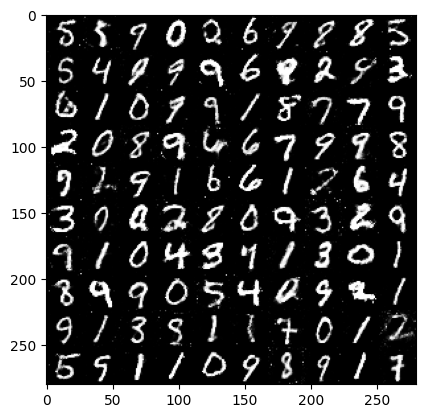

In [17]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [18]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

Question 1. Explain the code of the '1. Vanilla GAN' section "briefly".